In [83]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [84]:
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_subset_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 1995
end_year = 2015
exclude_countries = ['VEN', 'DZA']
rdata_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.Rdata'
model_params = {
    'use.mc.diff': True, 'use.mc.lev': False, 'use.mc.nonlin': False,
    'include.y': True, 'varname.y': 'ENI', 'lagTerms.y': 2,
    'fur.con': True, 'fur.con.diff': True, 'fur.con.lev': False,
    'varname.reg.fur': ['POP', 'AFL', 'AFL2', 'URB', 'CTS', 'TI', 'KAOPEN'],
    'lagTerms.reg.fur': [0] * 7,
    'include.dum': True, 'dum.diff': True, 'dum.lev': False,
    'w.mat': 'iid.err', 'std.err': 'corrected', 
    'estimation': 'twostep', 'opt.meth': 'none',
#     'estimation': 'iterative', 'opt.meth': 'BFGS',
    'inst.stata': False
}

**End of parameter section** 

In [85]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get rdata_file model_params

# SoS mangles dict keys, for no apparent reason
names(model_params) <- gsub('_', '.', names(model_params))

suppressMessages({
library(dplyr)
# library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))
#data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

Country,min,max
<fct>,<int>,<int>
ARG,1995,2014
AUS,1995,2015
BGR,1995,2014
BRA,1995,2014
CAN,1995,2015
CHE,1996,2014


In [86]:
model_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"    "AFL"    "AFL2"   "URB"    "CTS"    "TI"     "KAOPEN"

$lagTerms.reg.fur
[1] 0 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [87]:
base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(base_params, model_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary


Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
            Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)   
L1.ENI     0.1985526   0.0826214       2.403      0.01626 * 
L2.ENI     0.2280452   0.0959560       2.377      0.01745 * 
L0.POP    -0.0874482   0.0398911      -2.192      0.02838 * 
L0.AFL     0.0159004   0.0078483       2.026      0.04276 * 
L0.AFL2   -0.0115918   0.0156257      -0.742      0.45809   
L0.URB    -0.0481905   0.0232240      -2.075      0.03799 * 
L0.CTS    -0.3031074   0.2618436      -1.158      0.24686   
L0.TI     -0.1087523   0.1192936      -0.912      0.36177   
L0.KAOPEN  0.0170049   0.0151953       1.119      0.26314   
1998       0.0267032   0.0220628       1.210      0.22628   
1999       0.0275222   0.0256450       1.073      0.28327   
2000       0.0217456   0.0329918       0.659      0.50990   
2001       0.0009909   0.0170880       0.058      0.95375   
2002      -0.0086691   0.0115686      -0.749      0.45386   
2003   

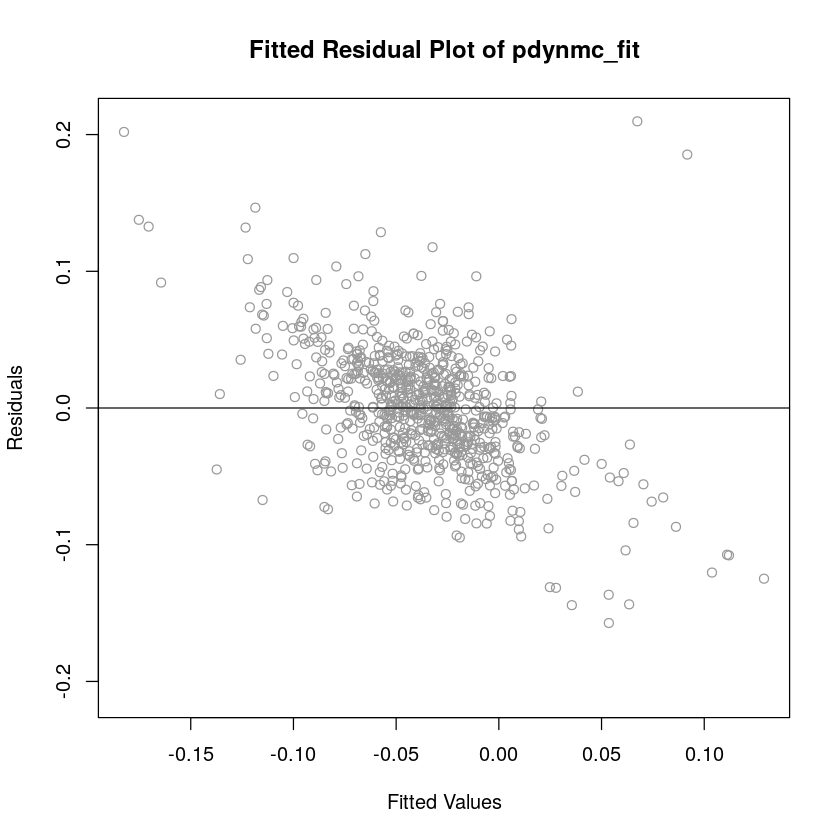

In [88]:
plot(pdynmc_fit)

In [89]:
ser.corr <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr


	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = -0.26236, p-value = 0.793


In [90]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,-1.258997e-14,chisq,1.000000e+00,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,3.973169e+03,chisq,0.000000e+00,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,3.783102e+02,chisq,3.010770e-69,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 2,-2.623646e-01,normal,7.930403e-01,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [91]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)
pdynmc_coef$index <- rownames(pdynmc_coef)
pdynmc_tests$index <- rownames(pdynmc_tests)
save(pdynmc_coef, pdynmc_tests, file=rdata_file)